# 在将做语义分割的模型之前还要一个操作

# 转置卷积
我们所见到的卷积神经网络层，例如卷积层（ 6.2节）和汇聚层（ 6.5节），通常会减少下采样输入图像的空间维度（高和宽）
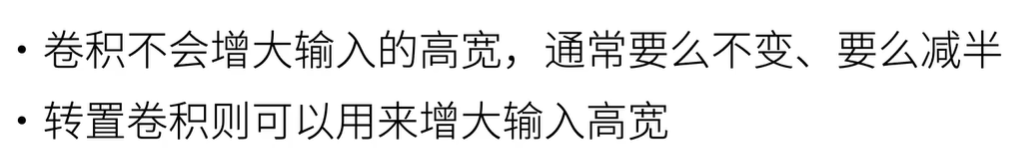
而转置卷积可以用来增大输入高宽即可以增加上采样中间层特征图的空间维度
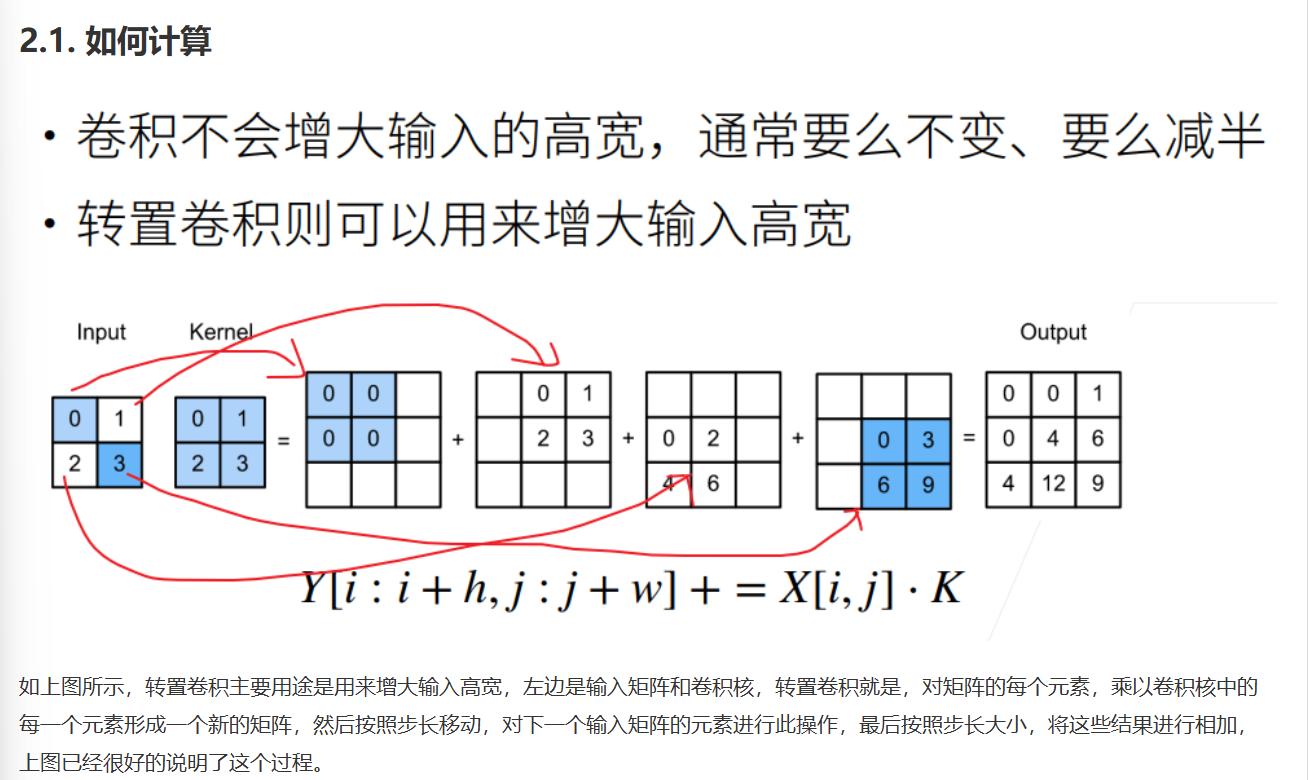


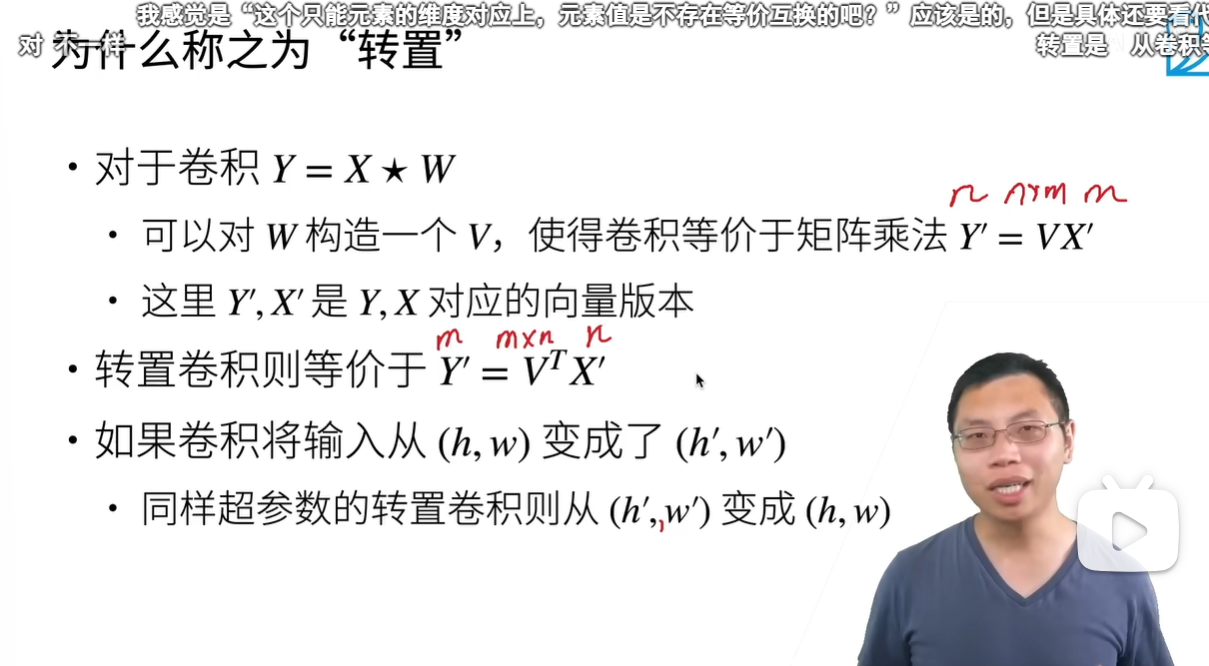

In [1]:
# 转置卷积的实现
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
# 实现基本的转置卷积
def trans_conv(X, K):
    # 获取卷积核 K 的高度和宽度
    h, w = K.shape
    
    # 创建一个零填充的输出矩阵 Y，尺寸为 (X行数 + 卷积核高度 - 1, X列数 + 卷积核宽度 - 1)
    Y = torch.zeros((X.shape[0] + h - 1, X.shape[1] + w - 1))
    
    # 遍历输入矩阵 X 的每一个元素
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # 对于输入矩阵 X 的每个元素，进行卷积操作
            # 将当前元素 X[i, j] 乘以卷积核 K，并累加到输出矩阵 Y 中对应的位置
            Y[i: i + h, j: j + w] += X[i, j] * K
    
    # 返回输出矩阵 Y
    return Y

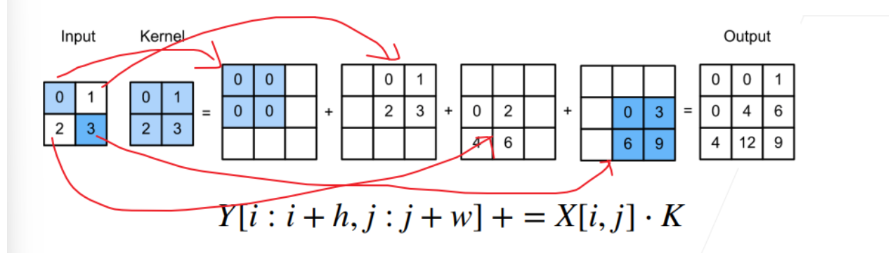

In [3]:
# 验证转置卷积的
X = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
trans_conv(X, K)

tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]])

In [5]:
# 使用API来调用
# 将输入矩阵 X 重塑为形状 (1, 1, 2, 2)
# 这里的形状是 (batch_size, 输入通道数, 高度, 宽度)
X = X.reshape(1, 1, 2, 2)

# 将卷积核 K 重塑为形状 (1, 1, 2, 2)
# 同样是 (输出通道数, 输入通道数, 卷积核高度, 卷积核宽度)
K = K.reshape(1, 1, 2, 2)

# 创建一个转置卷积层
# 输入通道数为 1，输出通道数为 1，卷积核尺寸为 2，且不使用偏置
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, bias=False)

# 将转置卷积层的权重设置为卷积核 K
tconv.weight.data = K

# 将输入 X 传递给转置卷积层，计算输出
output = tconv(X)
output

tensor([[[[ 0.,  0.,  1.],
          [ 0.,  4.,  6.],
          [ 4., 12.,  9.]]]], grad_fn=<ConvolutionBackward0>)

In [6]:
# 填充 步幅和多通道
# padding = 1 填充为1 
# 上下左右padding1 就是上下左右各减去一行（列）这么理解就行
tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, padding=1, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[4.]]]], grad_fn=<ConvolutionBackward0>)

In [7]:
# 步幅=2 即每次跳2格

tconv = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2, bias=False)
tconv.weight.data = K
tconv(X)

tensor([[[[0., 0., 0., 1.],
          [0., 0., 2., 3.],
          [0., 2., 0., 3.],
          [4., 6., 6., 9.]]]], grad_fn=<ConvolutionBackward0>)

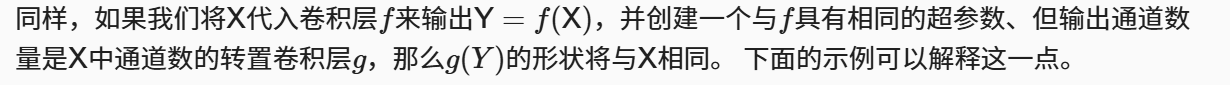

In [9]:
# 创建一个随机的输入张量 X，形状为 (1, 10, 16, 16)
# 其中 1 表示 batch_size，10 表示输入通道数，16x16 是输入特征图的高度和宽度
X = torch.rand(size=(1, 10, 16, 16))

# 创建一个普通卷积层，输入通道数为 10，输出通道数为 20，卷积核大小为 5
# 使用 padding=2 来保持特征图的尺寸，stride=3 控制卷积步幅
conv = nn.Conv2d(10, 20, kernel_size=5, padding=2, stride=3)

# 创建一个转置卷积层，输入通道数为 20，输出通道数为 10，
# 卷积核大小为 5，padding=2，stride=3（与上面的卷积层相配对）
tconv = nn.ConvTranspose2d(20, 10, kernel_size=5, padding=2, stride=3)

# 将输入 X 通过卷积层 conv 处理，然后再通过转置卷积层 tconv 处理
# 最后检查输出的形状是否与输入 X 的形状相同
output_shape_equal_to_X = tconv(conv(X)).shape == X.shape
output_shape_equal_to_X

True

In [10]:
# 与矩阵变换的联系
X = torch.arange(9.0).reshape(3, 3)
# 卷积核是K
K = torch.tensor([[1.0, 2.0], [3.0, 4.0]])
# 使用 d2l (Dive into Deep Learning) 库中的 corr2d 函数执行卷积操作
# 这里 X 是输入张量，K 是卷积核
Y = d2l.corr2d(X, K)
Y

tensor([[27., 37.],
        [57., 67.]])

In [12]:
# 我们将卷积核K重写为包含大量0的稀疏权重矩阵W。 
# 权重矩阵的形状是（4，9），其中非0元素来自卷积核K

def kernel2matrix(K):
    # 创建一个长度为5的零张量 k
    k = torch.zeros(5)
    # 创建一个形状为 (4, 9) 的零张量 W，用于存储结果矩阵
    W = torch.zeros((4, 9))
    
    # 将卷积核 K 的第一行（所有元素）复制到 k 的前两个位置
    k[:2], k[3:5] = K[0, :], K[1, :]
    
    # 将 k 的内容分配到 W 的四个不同位置
    W[0, :5] = k        # 第一行的前5个元素
    W[1, 1:6] = k      # 第二行的第2到第6个元素
    W[2, 3:8] = k      # 第三行的第4到第8个元素
    W[3, 4:] = k       # 第四行的第5个元素到最后
    
    # 返回构建的矩阵 W
    return W

# 调用 kernel2matrix 函数并传入卷积核 K
W = kernel2matrix(K)

# 输出结果矩阵 W
W

tensor([[1., 2., 0., 3., 4., 0., 0., 0., 0.],
        [0., 1., 2., 0., 3., 4., 0., 0., 0.],
        [0., 0., 0., 1., 2., 0., 3., 4., 0.],
        [0., 0., 0., 0., 1., 2., 0., 3., 4.]])

In [13]:
Y == torch.matmul(W, X.reshape(-1)).reshape(2, 2)

tensor([[True, True],
        [True, True]])

In [14]:
# 使用矩阵乘法来实现转置卷积

Z = trans_conv(Y, K)
Z == torch.matmul(W.T, Y.reshape(-1)).reshape(3, 3)

tensor([[True, True, True],
        [True, True, True],
        [True, True, True]])

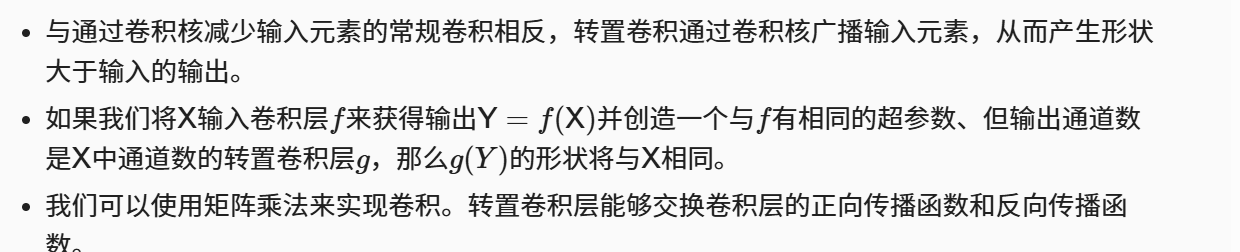